## Obtain the last trained model and predict scores for 10k random variants

In [1]:
from sklearn.externals import joblib
from kipoi_cadd.data import CaddSparseDataset
from kipoi_cadd.utils import load_pickle, dump_to_pickle
from tqdm import tqdm
from math import log
from kipoi_cadd.utils import variant_id_string
from scipy.sparse import csr_matrix, load_npz
import matplotlib.pyplot as plt
import cyvcf2
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
training_dir = "/s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/"
model_file = "/tmp/gin-train/a8eb036bfe3a495bbbcfc434e1c59bdd/model.h5"
scaler_cadd_file = "/s/project/kipoi-cadd/data/models/CADD1.4-GRCh37.scaler"
scaler_kipoicadd_file = "/s/project/kipoi-cadd/data/models/KipoiCadd-GRCh37.scaler"
sample_10k_ids_file = training_dir + "/variant_ids/sample_10k.pkl"
sample_10k_file = training_dir + "/sparse_matrices/sample_10k.npz"
vars_to_compare = training_dir + "sample_10k.vcf"
regions_txt = training_dir + "sample_10k_regions.txt"

In [ ]:
sample_10k_ids = load_pickle(sample_10k_ids_file)

### Load the model and the variants to be compared

In [18]:
clf = joblib.load(model_file)
scaler_kipoicadd = joblib.load(scaler_kipoicadd_file)
scaler_cadd = joblib.load(scaler_cadd_file)

## Get VCF file for the selected variants

In [17]:
def variants_to_basic_vcf(variants, output_file=None, n_lines=None):
    vcf_string = ""
    for i, var in enumerate(variants):
        if isinstance(var, cyvcf2.Variant):
            vcf_string += var.CHROM + "\t" + var.POS + "\t" + var.ID + "\t" + var.REF + "\t" + var.ALT[0] + "\n"
        else:
            chrom, pos, ref, alt = var.split(":")
            vcf_string += chrom + "\t" + pos + "\tv" + str(i+1) + "\t" + ref + "\t" + alt.split("'")[1] + "\n"
        if n_lines is not None:
            if i >= n_lines: break

    if output_file is not None:
        with open(output_file, "w") as f:
            f.write(vcf_string)
        return None
    else:
        return vcf_string
    
def variants_to_basic_regions(variants, output_file=None, n_lines=None):
    region_df = {'CHROM': [], 'POS': [], 'REF': [], 'ALT': []}
    for i, var in enumerate(variants):
        if isinstance(var, cyvcf2.Variant):
            # region_string += var.CHROM + "\t" + var.POS + "\n"
            region_df['CHROM'].append(int(var.CHROM))
            region_df['POS'].append(int(var.POS))
            region_df['REF'].append(var.REF)
            region_df['ALT'].append(var.ALT[0])
        else:
            chrom, pos, ref, alt = var.split(":")
            # region_string += chrom + "\t" + pos + "\n"
            if chrom == 'X' or chrom == 'Y':
                region_df['CHROM'].append(chrom)                
            else:
                region_df['CHROM'].append(int(chrom))
            region_df['POS'].append(int(pos))
            region_df['REF'].append(ref)
            region_df['ALT'].append(alt.split("'")[1])
    
        if n_lines is not None:
            if i >= n_lines: break
    
    df = pd.DataFrame(region_df)
    df.sort_values(by=['CHROM', 'POS'], inplace=True)
    # df['region'] = [':'.join([str(r.CHROM), str(r.POS) + "-" + str(r.POS), "1/" + r.ALT]) for r in df.itertuples()]
    # SNP
    # 5:140532-140532:1/C
    if output_file is not None:
        # df.region.to_csv(output_file, sep='\t', index=None, header=None)
        df.to_csv(output_file, sep='\t', index=None, header=None)
        return None
    else:
        return df

# variants_to_basic_regions(sample_10k_ids, regions_txt)
# variants_to_basic_vcf(sample_10k_ids, vars_to_compare)

Use this script:
``tabix -R /s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/sample_10k_regions.txt /s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/all.vcf.gz > /s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/sample_10k.vcf``

## a. Use CADD's package to get their scores
Used this command:
`./CADD.sh -g GRCh37 -o /s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/sample_10k.tsv.gz /s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/sample_10k.vcf`

In [5]:
cadd_vcf_output = training_dir + "sample_10k.tsv.gz"

In [6]:
cadd_scores = pd.read_csv(cadd_vcf_output, sep='\t', comment="#", header=None, names=['CHROM', 'POS', 'REF', 'ALT', 'CADD_RAW', 'CADD_PHRED'])
print(cadd_scores.shape)
cadd_scores.head()

(10095, 6)


,CHROM,POS,REF,ALT,CADD_RAW,CADD_PHRED
0,1,904778,T,C,0.003038,2.669
1,1,1211757,T,C,-1.025370,0.002
2,1,1343217,G,A,0.422567,8.626
3,1,1362172,A,G,0.005167,2.702
4,1,1880754,T,C,-0.279130,0.420


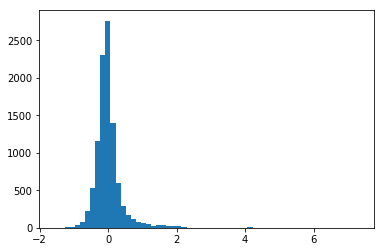

In [7]:
plt.hist(cadd_scores.CADD_RAW, bins=60);
plt.show()

In [8]:
desired = pd.read_csv(regions_txt, sep='\t', header=None, names=['CHROM', 'POS', 'REF', 'ALT'])
found_vars = pd.merge(desired, cadd_scores, how='inner', on=['CHROM', 'POS', 'REF', 'ALT'])
print(found_vars.shape)

(9999, 6)


In [9]:
found_var_ids = [variant_id_string(r.CHROM, r.POS, r.REF, r.ALT) for r in found_vars.itertuples()]

In [10]:
found_var_nums = []
for found_var in tqdm(found_var_ids):
    for var_num, var_id in sample_10k_ids.items():
        if var_id == found_var:
            found_var_nums.append(var_num)

100%|██████████| 9999/9999 [00:25<00:00, 394.43it/s]


In [11]:
sdf = pd.DataFrame(sample_10k_ids, columns=['var_id'])
sdf['locs'] = [x for x in range(sdf.shape[0])]

In [19]:
found_var_idx = sdf.loc[found_var_nums].locs
sample_10k = load_npz(sample_10k_file)
X_found_csr = sample_10k[found_var_idx, 1:]
scaler_cadd.transform(X_found_csr)
y_found = sample_10k[found_var_idx, 0].toarray().ravel()
X_found_csr.shape

(9999, 904)

In [20]:
y_found

array([0., 0., 0., ..., 0., 1., 1.], dtype=float32)

## Get log odd ratios of my scores
Obtain log odd ratios:

In [24]:
y_pred_kipoi_found = clf.decision_function(X_found_csr).flatten()
y_pred_kipoi_found

array([-1.17476608e+04, -3.27527844e+01, -1.68456817e+06, ...,
       -5.94736259e+03,  7.67662269e+00,  7.51650037e+00])

In [27]:
model_cadd_file = "/s/project/kipoi-cadd/data/models/CADD1.4-GRCh37.mod"
model_cadd, scaler_cadd = joblib.load(model_cadd_file)

sample_10k = load_npz(sample_10k_file)
X_found_csr = sample_10k[found_var_idx, 1:]
scaler_cadd.transform(X_found_csr)
y_found = sample_10k[found_var_idx, 0].toarray().ravel()
X_found_csr.shape

y_pred_cadd = model_cadd.decision_function(X_found_csr).flatten()
y_pred_cadd

/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-cadd2/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/modules/i12g/anaconda/3-5.0.1/envs/kipoi-cadd2/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


array([-2.90280019e+00, -1.51981960e-01, -5.79633360e+03, ...,
       -4.94693157e+00,  1.71736249e-02, -2.91023290e-01])

### b. 1. Calculate Pearson Correlation between my scores and theirs

In [25]:
from scipy.stats import pearsonr
pearsonr(y_pred_kipoi_found, found_vars.CADD_RAW)

(0.018407760599952087, 0.06567875551988807)

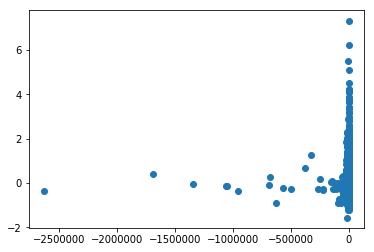

In [26]:
plt.scatter(y_pred_kipoi_found, found_vars.CADD_RAW);
plt.show()

## Evaluate accuracy by class

In [3]:
clf = joblib.load(model_file)
ds = CaddDataset(lmdb_dir, shuff_10k_file)
X, y = ds.load_all(shuffle=False)

# Do the same process as the trainer
X_sparse = csr_matrix(X, shape=None, dtype=np.float32, copy=True)
X = X_sparse
y = y.astype(np.float32)
del X_sparse

100%|██████████| 157/157 [00:00<00:00, 648.88it/s]


In [22]:
X_pos, y_pos = X[y.nonzero()[0],:], y[y.nonzero()[0]]
X_neg, y_neg = X[np.where(y == 0)[0]], y[np.where(y == 0)[0]]

In [24]:
score_pos = clf.score(X_pos, y_pos)
score_pos

0.5378680203045685

In [25]:
score_neg = clf.score(X_neg, y_neg)
score_neg

0.587192118226601

In [19]:
from kipoi_cadd.utils import load_pickle
import pandas as pd

allids = load_pickle("/s/project/kipoi-cadd/data/raw/v1.4/training_data/GRCh37/variant_ids/train.pkl")
allids.head()

19439457    13:97848895:T:['C']
19010394    13:19188334:A:['G']
25291760    3:196345832:C:['T']
26115442    4:147359634:T:['C']
25790477     4:85883965:T:['A']
dtype: object